In [3]:
import pandas as pd
import numpy as np
from pycaret.regression import setup, compare_models, blend_models,tune_model,predict_model,get_config, finalize_model

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.family'] = 'Gulim'

In [4]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [5]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


## 전처리
- 일자에서 월과 일을 분리
- 요일을 레이블 인코딩화(EDA로 요일의 중요도 순 파악)
- 월 별, 일 별 중식 석식 수요 차이 파악

In [6]:
train['월'] = pd.DatetimeIndex(train['일자']).month
test['월'] = pd.DatetimeIndex(test['일자']).month

train['일'] = pd.DatetimeIndex(train['일자']).day
test['일'] = pd.DatetimeIndex(test['일자']).day

In [5]:
weekday = {
    '월': 1,
    '화': 2,
    '수': 3,
    '목': 4,
    '금': 5
}

train['요일'] = train['요일'].map(weekday)
test['요일'] = test['요일'].map(weekday)

In [6]:
train['식사가능자수'] = train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

In [7]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,월,일,식사가능자수
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2,1,2551.0
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2,2,2551.0
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2,3,2545.0
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,2,4,2497.0
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,2,5,2323.0


## simple EDA

### 요일 별 중식, 석식 수요

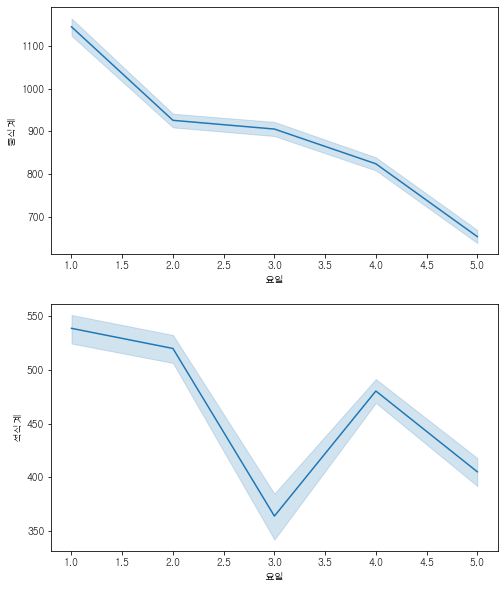

In [8]:
fig, ax = plt.subplots(2)
fig.set_size_inches(8,10)
sns.lineplot(data=train, x='요일', y='중식계', ax=ax[0])
sns.lineplot(data=train, x='요일', y='석식계', ax=ax[1])
plt.show()

- 중식의 경우 금요일로 갈수록 비슷한 양상으로 줄어드는 경향을 보임
- 하지만 석식의 경우 수요일이 가장 낮은 수요를 보임 -> 이를 참고하여 레이블 인코딩

### 요일 레이블 인코딩

In [9]:
weekday_rank4dinner = {
    1: 1,
    2: 2,
    3: 5,
    4: 3,
    5: 4,
}

train['요일(석식)'] = train['요일'].map(weekday_rank4dinner)
test['요일(석식)'] = test['요일'].map(weekday_rank4dinner)

In [10]:
train. head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,월,일,식사가능자수,요일(석식)
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2,1,2551.0,1
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2,2,2551.0,2
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2,3,2545.0,5
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,2,4,2497.0,3
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,2,5,2323.0,4


### 월별

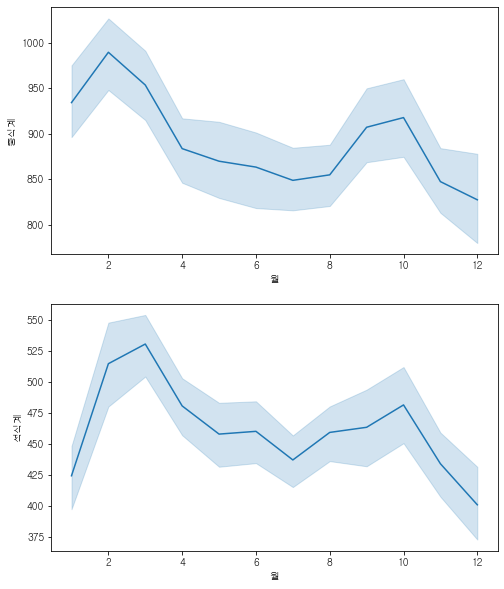

In [11]:
fig, ax = plt.subplots(2)
fig.set_size_inches(8,10)
sns.lineplot(data=train, x='월', y='중식계', ax=ax[0])
sns.lineplot(data=train, x='월', y='석식계', ax=ax[1])
plt.show()

- 중식은 2월, 석식은 3월이 가장 수요가 많음
- 월별로 중식, 석식의 큰 차이가 없음

### 월 레이블 인코딩

In [12]:
pd.pivot_table(train,values='중식계',index='월').sort_values(by='중식계')

,중식계
월,
12,827.336634
11,847.333333
7,848.736364
8,854.785047
6,863.311111
5,869.787879
4,883.621359
9,907.148936
10,917.771739


In [13]:
month_rank4lunch = {
    1: 3,
    2: 1,
    3: 2,
    4: 6,
    5: 7,
    6: 8,
    7: 10,
    8: 9,
    9: 5,
    10: 4,
    11: 11,
    12: 12
}
train['월(중식)'] = train['월'].map(month_rank4lunch)
test['월(중식)'] = test['월'].map(month_rank4lunch)

In [14]:
pd.pivot_table(train,values='석식계',index='월').sort_values(by='석식계')

,석식계
월,
12,401.168317
1,424.564356
11,434.250000
7,437.300000
5,458.131313
8,459.485981
6,460.355556
9,463.617021
4,480.825243


In [15]:
month_rank4dinner = {
    1: 11,
    2: 2,
    3: 1,
    4: 4,
    5: 8,
    6: 6,
    7: 9,
    8: 7,
    9: 5,
    10: 3,
    11: 10,
    12: 12
}
train['월(석식)'] = train['월'].map(month_rank4dinner)
test['월(석식)'] = test['월'].map(month_rank4dinner)

In [16]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,월,일,식사가능자수,요일(석식),월(중식),월(석식)
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2,1,2551.0,1,1,2
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2,2,2551.0,2,1,2
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2,3,2545.0,5,1,2
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,2,4,2497.0,3,1,2
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,2,5,2323.0,4,1,2


## 텍스트(메뉴) 전처리

### train/test에서 중복 메뉴만 변수로서 사용

In [17]:
menu_train = train[['조식메뉴','중식메뉴','석식메뉴']]
menu_test = test[['조식메뉴','중식메뉴','석식메뉴']]
print(menu_train.shape)
print(menu_test.shape)

(1205, 3)
(50, 3)


In [18]:
def clean_split(df):
    df = df.split()
    for j in df:
        if '(' in j:
            del df[df.index(j)]
    for i in df:
        if '쌀밥' in i:
            del df[df.index(i)] 
    for q in df:
        if '김치' in q:
            del df[df.index(q)]
    
    return df

In [19]:
menu_train['조식메뉴_prepro'] = menu_train['조식메뉴'].apply(clean_split)
menu_train['중식메뉴_prepro'] = menu_train['중식메뉴'].apply(clean_split)
menu_train['석식메뉴_prepro'] = menu_train['석식메뉴'].apply(clean_split)

menu_test['조식메뉴_prepro'] = menu_test['조식메뉴'].apply(clean_split)
menu_test['중식메뉴_prepro'] = menu_test['중식메뉴'].apply(clean_split)
menu_test['석식메뉴_prepro'] = menu_test['석식메뉴'].apply(clean_split)

In [20]:
lunch_train= menu_train.중식메뉴_prepro.tolist()
lunch_test= menu_test.중식메뉴_prepro.tolist()
dinner_train = menu_train.석식메뉴_prepro.tolist()
dinner_test = menu_test.석식메뉴_prepro.tolist()

In [21]:
lunch_list_train = []
for i in lunch_train:
    if len(i) == 0:
        continue
    else:
        string = i[0]
    for w in i[1:]:
        string += " "
        string += w
    lunch_list_train.append(string)
lunch_list_train

['오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트',
 '가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이',
 '카레덮밥 팽이장국 치킨핑거 쫄면야채무침 견과류조림 요구르트',
 '쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트',
 '떡국 돈육씨앗강정 우엉잡채 청경채무침 요구르트',
 '시래기국 훈제오리구이 도토리묵무침 쌈무/양파절임 요구르트',
 '꽃게탕 돈육굴소스볶음 옥수수전 유채나물 요구르트',
 '시금치국 닭감자조림 연두부*양념장 콩나물무침 요구르트',
 '쇠고기무국 탕수어 오징어숙회무침 취나물 요구르트',
 '냉이된장국 쇠고기장조림 통도라지구이 치커리무침 요구르트',
 '낙지비빔밥 유부장국 고구마치즈구이 해초무침 요구르트 요구르트',
 '대구찌개 마늘간장치킨 새송이버섯볶음 돌나물무침/치킨무 요구르트',
 '쇠고기느타리국 갈치구이 호박꼬지&고사리&무나물 파래김*양념장 부럼/요구르트',
 '콩나물국 돈육간장볶음 버섯잡채 꽃상추무침 요구르트',
 '비빔밥 팽이장국 소세지피망볶음 맛탕 귤 요구르트',
 '북어계란국 닭갈비 새싹두부구이 곰피초장 요구르트',
 '수제비국 오징어볶음 계란찜 도라지초무침 요구르트',
 '얼갈이된장국 제육볶음 늙은호박전 치커리생채 요구르트',
 '쇠고기미역국 주꾸미볶음 맛살계란말이 아삭고추무침',
 '근대된장국 탕수육 새송이버섯조림 무생채 요구르트',
 '부대찌개 가자미튀김 메추리알조림 열무된장나물 깍두기',
 '콩나물국 닭갈비 모둠묵*양념장 톳두부무침',
 '차돌박이찌개 소세지구이 풋마늘초무침 깍두기',
 '북어국 돈육장조림 홍어무침 시금치나물',
 '고추장찌개 닭데리야끼조림 해물파전 취나물',
 '배추된장국 수제돈가스 탕평채 쫄면무침',
 '어묵국 돈육고추장볶음 모둠양채쌈*쌈장 콩나물파채무침',
 '쑥국 소불고기 골뱅이무침*소면 마늘쫑볶음',
 '곤드레밥 미니채소떡갈비 두부계란부침 무나물',
 '사골우거지국 탕수어 파래김*양념장 깻순나물 깍두기',
 '시금치국 훈제오리구이 연근땅콩조림 쌈무/부추생채',
 '꽃게탕 버섯불고기

In [22]:
lunch_list_test = []
for i in lunch_test:
    if len(i) == 0:
        continue
    else:
        string = i[0]
    for w in i[1:]:
        string += " "
        string += w
    lunch_list_test.append(string)
lunch_list_test

['대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 양상추샐러드*딸기D',
 '우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 양상추샐러드*오미자D',
 '팽이장국 수제돈까스*소스 가자미조림 동초나물무침 양상추샐러드*파인요거트D',
 '배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 양상추샐러드*망고D',
 '부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 양상추샐러드*오리엔탈D',
 '아욱국 매콤해물볶음 감자조림 미나리나물 콥샐러드*렌치D',
 '설렁탕 볼어묵굴소스볶음 브로콜리숙회*초장 석박지 양상추샐러드*키위D',
 '북엇국 닭볶음탕 채소전*장 솎음열무나물무침 양상추샐러드*황도D',
 '감자양파국 돈수육*씨앗쌈장 매콤어묵볶음 콩나물파채무침 양상추샐러드*자몽D',
 '장각백숙 적어양념장구이 채소스틱*쌈장 도라지오이초무침 양상추샐러드*참깨D',
 '유니짜장밥 짬뽕국 수제찹쌀꿔바로우 계란후라이 단무지락교무침 그린샐러드*딸기요거트D',
 '떡국 소갈비찜 한식잡채 참나물겉절이 양상추샐러드*블루베리요거트D',
 '육개장 닭살겨자냉채 오이스틱*쌈장 탕평채 깍두기/수박 양상추샐러드*오렌지D',
 '미니쌀국수 삼겹살고추장구이 스프링롤*타르타르D 동초나물무침 양상추샐러드*오리엔탈D',
 '수원왕갈비통닭 두부양념조림 연근깨소스무침 양상추샐러드*파인D',
 '유부장국 해물누룽지탕 마약계란장조림 양상추샐러드*딸기D',
 '호박고추장찌개 안동찜닭 마카로니치즈범벅 세발나물무침 양상추샐러드*감귤D',
 '근대국 감자채전*장 치커리무침 깍두기 파스타샐러드',
 '해물탕 쇠고기숙주볶음 맛살계란말이 물미역초고추장무침 양상추샐러드*석류D',
 '나주곰탕 생선까스*타르타르D 더덕양념구이 방풍나물무침 석박지 그린샐러드*키위요거트D',
 '옹심이국 목살스테이크 베이비크랩강정 양상추샐러드*망고D',
 '아욱국 치즈불닭 베이컨감자볶음 매운콩나물무침 양배추샐러드*사우전D',
 '황태미역국 동파육 느타리버섯볶음 참나물상추겉절이 양상추샐러드*블루베리요거트D',
 '매운쇠고기샤브샤브국 갈치조림 수수부꾸미 쑥

In [23]:
dinner_list_train = []
for i in dinner_train:
    if len(i) == 0:
        i = ['.']
        string = i[0]
    else:
        string = i[0]
    for w in i[1:]:
        string += " "
        string += w
    dinner_list_train.append(string)
dinner_list_train

['육개장 자반고등어구이 두부조림 건파래무침',
 '콩나물밥*양념장 어묵국 유산슬 아삭고추무침 바나나',
 '청국장찌개 황태양념구이 고기전 새송이버섯볶음',
 '미니김밥*겨자장 우동 멕시칸샐러드 군고구마 무피클',
 '차돌박이찌개 닭갈비 감자소세지볶음 콩나물무침',
 '참치회덮밥 맑은국 군만두 과일샐러드 락교',
 '미니함박 어묵볶음 물파래무침 깍두기',
 '홍합미역국 임연수구이 브로컬리초장',
 '된장찌개 쇠불고기 해파리겨자채 봄동무침',
 '볶음밥*자장소스 맑은국 새우또띠아 쨔샤이무침 요플레',
 '순두부찌개 명태조림 감자채볶음 쌈만두',
 '설렁탕 야채스틱 바나나 석박지',
 '옹심이만두국 떡갈비조림 청포묵무침 부추오이생채',
 '콩비지찌개 해물까스&타르타르소스 볶음쌀국수 미역레몬초무침 통배추겉절이',
 '열무된장국 매운돼지갈비찜 멸치호두볶음 숙주나물',
 '김밥 잔치국수 교자만두 찜) 멕시칸샐러드 무피클',
 '닭개장 삼치구이 꽃맛살볶음 청경채사과무침',
 '버섯들깨탕 꽁치한마리구이 두부양념조림 구이김',
 '된장찌개 버섯불고기 콩나물겨자채 양념깻잎지',
 '멸치주먹밥 우동 떡볶이 군고구마 단무지',
 '오징어국 미트볼조림 옥수수전 부추생채',
 '대구찌개 돈육굴소스볶음 감자채볶음 물파래무침',
 '카레덮밥 가쯔오장국 수제고로케*케찹 과일샐러드 오복지',
 '육개장 생선까스*탈탈소스 야채계란찜 콩나물무침',
 '볶음밥 짬뽕 개성감자만두 타코야끼 꼬들단무지',
 '연두부탕 코다리무조림 고추잡채*꽃빵 봄동겉절이',
 '달래된장찌개 간장찜닭 통도라지구이 참나물생채',
 '짜장잡채덮밥 계란파국 참치야채전 꽃맛살샐러드 오이무침',
 '뼈해장국 해물청경채볶음 버섯메밀전 야채스틱*쌈장',
 '토마토스파게티 양송이스프 미니햄버거 단호박범벅 무피클/음료',
 '닭곰탕 임연수찜 어묵곤약볶음 돌나물초장 석박지',
 '수제비국 아귀콩나물찜 새송이버섯볶음 봄동겉절이',
 '굴소스파인볶음밥 가쯔오장국 찹쌀순대볶음 궁중떡찜 두반장가지나물',
 '알탕 동그랑땡전 마파두부 시금치나물

In [24]:
dinner_list_test = []
for i in dinner_test:
    if len(i) == 0:
        i = ['.']
        string = i[0]
    else:
        string = i[0]
    for w in i[1:]:
        string += " "
        string += w
    dinner_list_test.append(string)
dinner_list_test

['흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음',
 '충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지',
 '흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침',
 '흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침',
 '흑미밥 바지락살국 쇠고기청경채볶음 머위된장무침',
 '오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지',
 '흑미밥 계란파국 돈육두루치기 감자채파프리카볶음 세발나물오리엔탈무침',
 '유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이',
 '흑미밥 냉이국 반반치킨 꼬막채소무침 청경채찜',
 '흑미밥 미역국 매운소불고기 단호박두부탕수 메추리알장조림 석박지',
 '흑미밥 오징어굴소스볶음 차돌비빔국수 건새우무나물',
 '흑미밥 순두부백탕 수제치킨까스 쫄면채소무침 얼갈이나물',
 '흑미밥 손수제비국 쇠고기낙지볶음 카레홍합찜 쑥갓나물',
 '곤드레밥 황태국 찰떡떡갈비조림 계란후라이 재래김*달래양념장 무생채',
 '흑미밥 바지락된장찌개 제육볶음 양배추숙*쌈장 노가리고추조림',
 '흑미밥 버섯들깨탕 아귀콩나물찜 콤비네이션피자 돌나물&된장소스',
 '흑미밥 동태알탕 깐풍육 고사리볶음 오이무침',
 '흑미밥 쇠고기무국 춘전닭갈비 뉴욕핫도그 유채나물된장무침',
 '애플카레라이스 팽이장국 가지탕수 소떡소떡 오복지무침',
 '흑미밥 계란파국 쭈꾸미불고기 모둠채소전*장 씨앗콩자반',
 '흑미밥 삼치구이*와사비장 브로콜리깨소스무침 연근조림',
 '흑미밥 냉이김칫국 해물우동볶음 날치알계란찜 솎음열무나물',
 '흑미밥 매운족발볶음 크래미오이보트샐러드 청경채나물',
 '흑미밥 짬뽕국 쇠고기탕수 고추잡채*꽃빵 해초배무침',
 '샐러드김밥 미소시루 라볶이 단무지채무침',
 '흑미밥 달래된장찌개 코코뱅 고구마치즈구이 치커리무침',
 '흑미밥 맑은콩나물국 수제두부동그랑땡 유채나물무침',
 '흑미밥 순두부백탕 낙지볶음 쇠고기들깨소스무침 쪽파무침',
 '꽁보리밥*볶음고추장 닭칼국수 왕만두찜*양념장 버섯맛살볶음 양파장아찌 얼갈

## 벡터화

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
lunch_matrix_train = vectorizer.fit_transform(lunch_list_train)
lunch_df_train = pd.DataFrame(lunch_matrix_train.toarray(), columns=vectorizer.get_feature_names())

vectorizer = TfidfVectorizer()
dinner_matrix_train = vectorizer.fit_transform(dinner_list_train)
dinner_df_train = pd.DataFrame(dinner_matrix_train.toarray(), columns=vectorizer.get_feature_names())

vectorizer = TfidfVectorizer()
lunch_matrix_test = vectorizer.fit_transform(lunch_list_test)
lunch_df_test = pd.DataFrame(lunch_matrix_test.toarray(), columns=vectorizer.get_feature_names())

vectorizer = TfidfVectorizer()
dinner_matrix_test = vectorizer.fit_transform(dinner_list_test)
dinner_df_test = pd.DataFrame(dinner_matrix_test.toarray(), columns=vectorizer.get_feature_names())

In [26]:
# 중복 메뉴 선정
lunch_intersection = list(set(lunch_df_train.columns) & set(lunch_df_test.columns))
print(len(lunch_intersection))
dinner_intersection = list(set(dinner_df_train.columns) & set(dinner_df_test.columns))
print(len(dinner_intersection))

146
109


## 최종 데이터 셋 구축

In [27]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '월', '일', '식사가능자수',
       '요일(석식)', '월(중식)', '월(석식)'],
      dtype='object')

In [28]:
train

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,월,일,식사가능자수,요일(석식),월(중식),월(석식)
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2,1,2551.0,1,1,2
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2,2,2551.0,2,1,2
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2,3,2545.0,5,1,2
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,2,4,2497.0,3,1,2
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,2,5,2323.0,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,3,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0,1,20,2517.0,5,3,11
1201,2021-01-21,4,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0,1,21,2540.0,3,3,11
1202,2021-01-22,5,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0,1,22,2425.0,4,3,11
1203,2021-01-25,1,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0,1,25,2549.0,1,3,11


In [29]:
lunch_df_f = pd.concat([train[['요일','본사시간외근무명령서승인건수','현본사소속재택근무자수','월(중식)','식사가능자수','중식계']],lunch_df_train[lunch_intersection]],axis=1)
lunch_df_test_f = pd.concat([test[['요일','본사시간외근무명령서승인건수','현본사소속재택근무자수','월(중식)','식사가능자수']],lunch_df_test[lunch_intersection]],axis=1)

dinner_df_f = pd.concat([train[['요일(석식)','본사시간외근무명령서승인건수','현본사소속재택근무자수','월(석식)','식사가능자수','석식계']],dinner_df_train[dinner_intersection]],axis=1)
dinner_df_test_f = pd.concat([test[['요일(석식)','본사시간외근무명령서승인건수','현본사소속재택근무자수','월(석식)','식사가능자수']],dinner_df_test[dinner_intersection]],axis=1)

In [30]:
print(lunch_df_f.shape)
print(lunch_df_test_f.shape)

(1205, 152)
(50, 151)


In [31]:
print(dinner_df_f.shape)
print(dinner_df_test_f.shape)

(1205, 115)
(50, 114)


In [32]:
lunch_df_f.head(2)

,요일,본사시간외근무명령서승인건수,현본사소속재택근무자수,월(중식),식사가능자수,중식계,통들깨부추무침,참나물겉절이,수박,매콤해물볶음,자몽d,닭볶음탕,바베큐폭립,치커리무침,사우전d,육개장,탕평채,두부까스,열무된장국,근대국,맛살계란말이,두부양념조림,마카로니치즈범벅,요구르트,쫄면채소무침,키위요거트d,파인d,수제돈까스,소스,냉이된장국,시금치프리타타,고등어구이,오이생채,참깨d,황태미역국,감자양파국,도토리묵,호박고추장찌개,문어꽈리고추조림,황도d,가지나물,적어양념장구이,유채나물무침,키위d,돈갈비찜,시리얼샐러드,양상추샐러드,설렁탕,청양부추전,도라지오이초무침,장어강정,유부장국,닭살겨자냉채,동태매운탕,부추고추장무침,매실d,오미자d,그린샐러드,쇠고기숙주볶음,삼색유자청무침,짬뽕국,와사비장,마카로니콘샐러드,김말이강정,어묵잡채,시저d,동파육,매운콩나물무침,목살스테이크,수원왕갈비통닭,부추무침,쇠고기미역국,대파육개장,취나물무침,나주곰탕,오리엔탈d,미역국,봄나물비빔밥,쌈장,아욱국,양념간장,사골우거지국,콩나물불고기,오꼬노미계란말이,세발나물무침,콩가루배추국,풋마늘대무침,건새우호박채전,닭개장,석류d,안동찜닭,팽이장국,근대된장국,양배추샐러드,채소스틱,깍두기,우렁된장찌개,한식잡채,감자조림,콩나물파채무침,부대찌개,아삭이고추된장무침,갈비탕,딸기d,망고d,오리주물럭,감자채전,쑥갓두부무침,쑥국,유부채소겨자냉채,파스타샐러드,갈치조림,춘천닭갈비,오리불고기,순대국밥,바나나,상추무침,생선까스,초장,오렌지d,씨앗쌈장,골뱅이채소무침,오리대패불고기,방풍나물,발사믹d,쌈채소,석박지,순남시래기국,도라지오이생채,양념장,어묵매운탕,브로콜리숙회,소갈비찜,딸기요거트d,계란후라이,돈육간장불고기,묵은지닭찜,얼갈이된장국,감귤d,황태국,버섯매운탕,생강채,청경채찜,흑임자d,콥샐러드,북엇국,비름나물,떡국,매운돈갈비찜,소불고기,요거트d,해물누룽지탕
0,1,238,0.0,1,2551.0,1039.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,319,0.0,1,2551.0,867.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.402497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
dinner_df_f.head(2)

,요일(석식),본사시간외근무명령서승인건수,현본사소속재택근무자수,월(석식),식사가능자수,석식계,충무김밥,제육볶음,삼치엿장구이,짜사이볶음,오이무침,무생채,치커리무침,사골파국,근대국,코다리무조림,쫄면채소무침,깐풍육,쇠고기청경채볶음,추가밥,오므라이스,시금치된장국,순두부백탕,꽃빵,매운감자조림,쇠고기우엉볶음,쇠고기무국,순대찜,오징어어묵무침,얼갈이열무겉절이,국물떡볶이,맑은버섯국,짬뽕,라볶이,단무지채무침,우동국물,애호박나물,오복지무침,타르타르d,쇠고기숙주볶음,순두부찌개,짬뽕국,김칫국,와사비장,낙지볶음,맑은콩나물국,고구마치즈구이,날치알계란찜,브로콜리깨소스무침,애플카레라이스,열무나물무침,강된장,고추잡채,갈치구이,노가리고추조림,쇠고기규동덮밥,곤드레밥,취나물무침,아귀콩나물찜,미역국,수제치킨까스,쌈장,차돌된장찌개,오징어무침,알리오올리오,오꼬노미계란말이,수제오이피클,동태탕,세발나물무침,단무지무침,부추전,팽이장국,명엽채볶음,감자채파프리카볶음,달래된장찌개,춘권,깍두기,삼치구이,양념고추지,청경채나물,유부초밥,소금,부대찌개,뼈해장국,고들빼기무침,쑥갓나물,구운채소,미나리전,닭간장조림,상추무침,생선까스,오삼불고기,오징어굴소스볶음,참나물초장무침,꼬시래기무침,버섯들깨탕,석박지,양념장,가쓰오장국,어묵매운탕,계란후라이,도토리묵채소무침,치커리사과무침,황태국,꽃맛살샐러드,유채나물된장무침,연근땅콩조림,미니우동,소떡소떡,얼갈이나물,흑미밥,손수제비국,계란파국,연근조림,청경채겉절이
0,1,238,0.0,2,2551.0,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,319,0.0,2,2551.0,560.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.358487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 중식 예측모델

In [34]:
lunch_regression_model = setup(data=lunch_df_f, target='중식계', train_size=0.8,n_jobs=-1,fold = 5)

,Description,Value
0,session_id,4673
1,Target,중식계
2,Original Data,"(1205, 152)"
3,Missing Values,False
4,Numeric Features,115
5,Categorical Features,36
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(964, 162)"


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [122]:
# 최고 성능 모델 선정(2개)
lunch_regression_best_models = compare_models(fold=5, n_select=3, exclude=['huber','llar','lar','par','lasso'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,80.7075,11777.4738,108.4329,0.7337,0.1319,0.0979,0.5940
gbr,Gradient Boosting Regressor,81.2124,11847.6994,108.5927,0.7314,0.1327,0.0988,0.0520
lightgbm,Light Gradient Boosting Machine,84.4389,12582.8633,112.0706,0.7147,0.1384,0.1031,0.0160
rf,Random Forest Regressor,84.8038,13128.5989,114.2289,0.7021,0.1405,0.1033,0.0900
et,Extra Trees Regressor,89.1740,14519.3558,120.2861,0.6694,0.1452,0.1079,0.1000
xgboost,Extreme Gradient Boosting,88.1242,14569.6189,120.5840,0.6646,0.1476,0.1072,0.1540
ada,AdaBoost Regressor,95.4533,15042.1031,122.6014,0.6575,0.1516,0.1193,0.0360
ridge,Ridge Regression,93.5876,15271.4447,123.3413,0.6571,0.1540,0.1163,0.0060
omp,Orthogonal Matching Pursuit,96.1452,16114.6540,126.7566,0.6375,0.1576,0.1189,0.0060
dt,Decision Tree Regressor,109.8975,21789.2102,146.7175,0.4939,0.1814,0.1334,0.0080


In [123]:
lunch_regression_best_models_tuned = [tune_model(i, optimize='MAE') for i in lunch_regression_best_models]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,91.5213,14362.7467,119.8447,0.6998,0.1440,0.1075
1,76.7914,10255.5144,101.2695,0.7216,0.1184,0.0910
2,84.2624,12201.0460,110.4583,0.7097,0.1311,0.0996
3,82.6950,11862.4140,108.9147,0.7186,0.1538,0.1112
4,89.7569,14925.9968,122.1720,0.7245,0.1648,0.1180
Mean,85.0054,12721.5436,112.5318,0.7148,0.1424,0.1054
SD,5.2610,1711.3435,7.6241,0.0090,0.0163,0.0093


In [124]:
lunch_model_f = blend_models(estimator_list=lunch_regression_best_models_tuned, fold=5, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,86.5819,13349.7456,115.5411,0.7210,0.1367,0.1009
1,73.3211,10022.1062,100.1105,0.7280,0.1165,0.0870
2,80.3065,10590.8743,102.9120,0.7480,0.1221,0.0945
3,76.5913,10225.3825,101.1206,0.7575,0.1354,0.1018
4,81.1154,12310.0496,110.9507,0.7728,0.1465,0.1047
Mean,79.5832,11299.6316,106.1270,0.7454,0.1314,0.0978
SD,4.4725,1304.7859,6.0579,0.0190,0.0108,0.0063


In [125]:
pred = predict_model(lunch_model_f)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,74.3938,9472.4478,97.3265,0.7590,0.1202,0.0900


### 테스트 데이터 예측

In [126]:
submission = pd.read_csv('../data/sample_submission.csv')

In [127]:
final_model_lunch = finalize_model(lunch_model_f)
prep_pipe_lunch = get_config('prep_pipe')
prep_pipe_lunch.steps.append(['trained_model', final_model_lunch])

In [128]:
pred_lunch = prep_pipe_lunch.predict(lunch_df_test_f)

submission.iloc[:,1] = pred_lunch
submission.head()

,일자,중식계,석식계
0,2021-01-27,987.334528,0
1,2021-01-28,962.197590,0
2,2021-01-29,727.632760,0
3,2021-02-01,1192.116288,0
4,2021-02-02,997.024256,0


## 석식 예측모델

In [129]:
dinner_regression_model = setup(data=dinner_df_f, target='석식계', train_size=0.8,n_jobs=-1,fold = 5)

,Description,Value
0,session_id,8088
1,Target,석식계
2,Original Data,"(1205, 115)"
3,Missing Values,False
4,Numeric Features,68
5,Categorical Features,46
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(964, 120)"


In [130]:
dinner_regression_best_models = compare_models(fold=5, n_select=2, exclude=['huber','llar','lar','par','lasso'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,72.0469,11378.4210,106.4894,0.4092,1.1412,0.1400,0.0340
catboost,CatBoost Regressor,70.0136,11381.5614,106.5014,0.4054,1.1325,0.1365,0.5460
lightgbm,Light Gradient Boosting Machine,72.0508,11957.6469,109.0646,0.3797,1.1367,0.1387,0.0260
ridge,Ridge Regression,76.4743,12180.7727,110.1843,0.3674,1.1435,0.1538,0.0060
omp,Orthogonal Matching Pursuit,77.9984,12440.8871,111.2959,0.3545,1.1448,0.1563,0.0060
en,Elastic Net,78.6735,12536.1355,111.7887,0.3498,1.1500,0.1592,0.0060
br,Bayesian Ridge,79.6817,12759.1813,112.7754,0.3384,1.1517,0.1613,0.0080
rf,Random Forest Regressor,74.6939,12872.6963,113.2993,0.3294,1.1503,0.1460,0.0820
lr,Linear Regression,79.8699,12930.6479,113.5821,0.3252,1.1438,0.1622,0.0060
knn,K Neighbors Regressor,80.8727,13733.1473,116.8944,0.2911,1.1514,0.1625,0.0080


In [131]:
dinner_regression_best_models_tuned = [tune_model(i, optimize='MAE') for i in dinner_regression_best_models]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,72.9440,13051.1490,114.2416,0.4110,1.3660,0.1418
1,75.2902,11399.3377,106.7677,0.4004,1.0557,0.1536
2,70.8930,11386.6363,106.7082,0.4048,1.1359,0.1274
3,64.7971,8265.4672,90.9146,0.4504,0.8565,0.1436
4,70.1464,10765.2795,103.7559,0.4981,1.2853,0.1231
Mean,70.8141,10973.5739,104.4776,0.4329,1.1399,0.1379
SD,3.4994,1552.1238,7.6162,0.0371,0.1787,0.0111


In [132]:
dinner_model_f = blend_models(estimator_list=dinner_regression_best_models, fold=5, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,74.3168,13254.7888,115.1294,0.4018,1.3642,0.1431
1,71.6648,11099.6450,105.3549,0.4162,1.0560,0.1437
2,68.8767,11289.4724,106.2519,0.4099,1.1325,0.1241
3,66.8652,9638.5843,98.1763,0.3591,0.8525,0.1474
4,68.3848,10105.6623,100.5269,0.5289,1.2737,0.1195
Mean,70.0217,11077.6305,105.0879,0.4231,1.1358,0.1356
SD,2.6496,1249.0761,5.8452,0.0565,0.1777,0.0114


In [133]:
pred = predict_model(dinner_model_f)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,72.3310,11160.2935,105.6423,0.4129,1.0353,0.1576


### 테스트 데이터 예측

In [134]:
final_model_dinner = finalize_model(dinner_model_f)
prep_pipe_dinner = get_config('prep_pipe')
prep_pipe_dinner.steps.append(['trained_model', final_model_dinner])

In [135]:
pred_dinner = prep_pipe_dinner.predict(dinner_df_test_f)
submission.iloc[:,2] = pred_dinner
submission.head()

,일자,중식계,석식계
0,2021-01-27,987.334528,379.810014
1,2021-01-28,962.197590,468.935711
2,2021-01-29,727.632760,274.511271
3,2021-02-01,1192.116288,556.079393
4,2021-02-02,997.024256,517.253828


## 저장

In [136]:
import datetime
today = str(datetime.datetime.now().date()).replace("-","")
print("오늘 날짜 : " + today)

submission.to_csv(f'../submission/{today}_pycaret.csv', index =False)

오늘 날짜 : 20210622
